# Najprostszy klasyfikator i reprezentacja danych


1. Wybierz zbiór danych (najlepiej zawierający wartości liczbowe jako cechy
oraz cechy kategoryczne jako numery klas. Zbiór powinien być nietrywialny i
ma zawierać > 10 cech).

Wybrałem zbiór danych Wine, który ma 13 cech numerycznych, poniżej wczytuje i wyświetlam co w nim jest.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA

# Wczytanie zbioru danych Wine
data = load_wine()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target  # Dodajemy kolumnę z kategoriami klas
print(df.head())




   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  target  
0          

## Normalizacja danych
Użyłem StandardScaler() do standaryzacji danych.

In [2]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns=['target']))

### Dlaczego powinniśmy standaryzować/normalizować dane? 
Powinniśmy standaryzować dane ponieważ, dzięki temu otrzymujemy bardzije ujednolicone dane. Przez co nie faworyzujemy cech o dużych wartościach. Ponadto poprzez standaryzację otrzymujemy poprawiamy dokładność naszych modeli.

## Czy można rozpoznać klasy przy pomocy macierz odległości pomiędzy wektorami cech?

Tak, można rozpoznać klasy przy użyciu macierzy odległości pomiędzy wektorami cech. Jednym z popularnych podejść jest zastosowanie algorytmu k-NN, który klasyfikuje obiekt na podstawie jego najbliższych sąsiadów w przestrzeni cech.

## Obliczenie macierzy odległości i analiza separacji klas

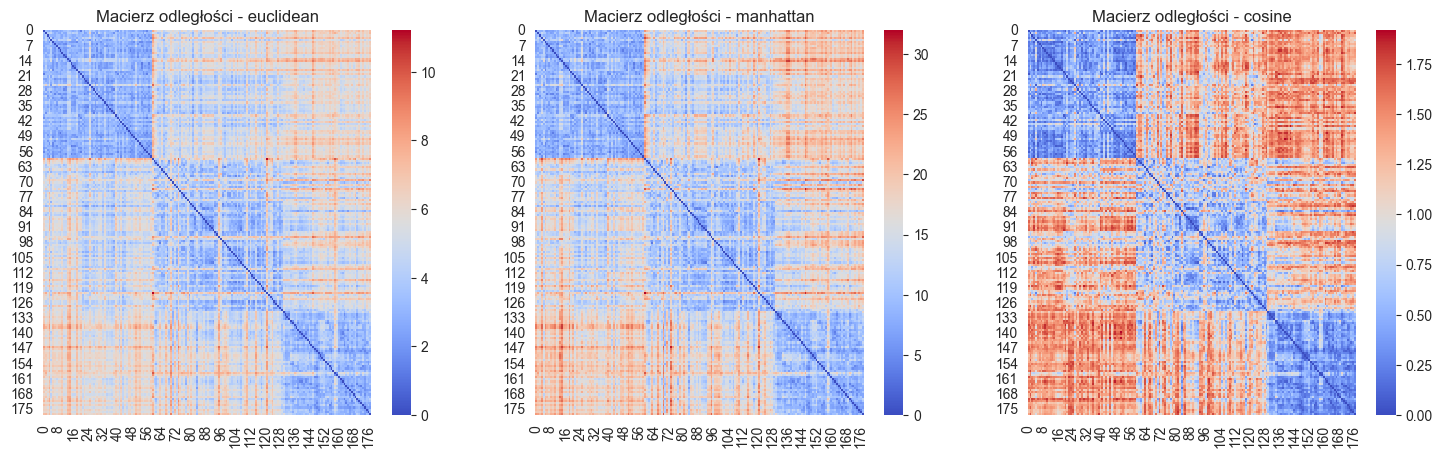

In [3]:
# Obliczenie macierzy odległości dla różnych metryk
distances = {
    'euclidean': pairwise_distances(X_scaled, metric='euclidean'),
    'manhattan': pairwise_distances(X_scaled, metric='manhattan'),
    'cosine': pairwise_distances(X_scaled, metric='cosine')
}

# Wizualizacja macierzy odległości
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (metric, matrix) in zip(axes, distances.items()):
    sns.heatmap(matrix, ax=ax, cmap='coolwarm')
    ax.set_title(f'Macierz odległości - {metric}')
plt.show()


### Wnioski
- Metryka kosinusowa (Cosine) najdobitniej ukazuje podział na klasy, co sugeruje, że może być najlepsza do klasyfikacji.
- Manhattan może być bardziej odporny na wartości odstające.
- Euklidesowa sprawdza się dobrze w przypadku danych o normalnym rozkładzie i dobrze rozdzielonych klasach.

## Sprawdzenie wpływu metryki na k-NN
Dla różnych metryk obliczymy dokładność klasyfikacji k-NN i wybierzemy najlepszą.

In [4]:
# Klasyfikacja k-NN dla różnych metryk
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df['target'], test_size=0.2, random_state=42)
metrics = ['euclidean', 'manhattan', 'cosine']

for metric in metrics:
    knn = KNeighborsClassifier(n_neighbors=5, metric=metric)
    scores = cross_val_score(knn, X_train, y_train, cv=5)
    print(f'Średnia dokładność k-NN dla metryki {metric}: {scores.mean():.4f}')


Średnia dokładność k-NN dla metryki euclidean: 0.9579
Średnia dokładność k-NN dla metryki manhattan: 0.9786
Średnia dokładność k-NN dla metryki cosine: 0.9648


### Wnioski:
- Metryka Manhattan okazała się najlepsza, co sugeruje, że wartości cech w tym zbiorze lepiej pasują do tego sposobu mierzenia odległości.
- Metryka Cosine również dobrze radzi sobie z klasyfikacją, ale nie jest optymalna w tym przypadku.
- Metryka Euklidesowa sprawdza się najgorzej, choć nadal daje bardzo wysoką dokładność.

Mimo, że wszystkie metryki mają bardzo dobre wyniki to metryki manhattan wygrywa z innymi.

## Redukcja wymiarów PCA
Redukcja danych do 3 cech za pomocą PCA, a następnie powtarzam eksperyment, porównując wyniki.

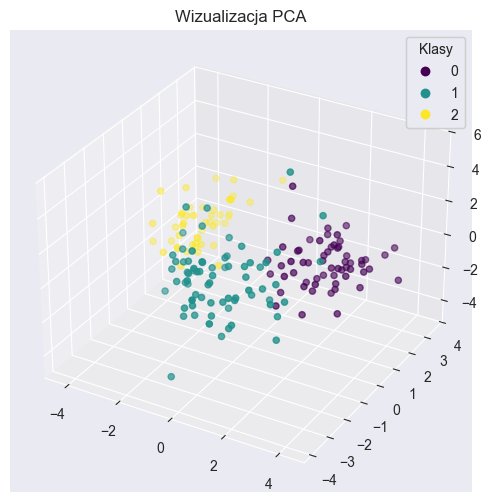

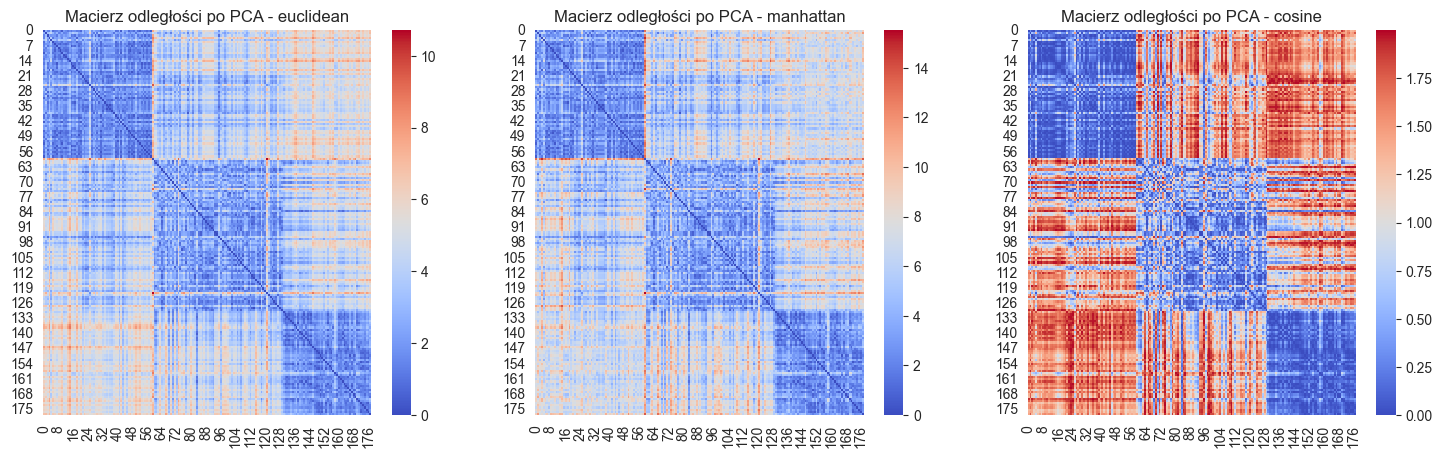

In [5]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Wizualizacja PCA
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=df['target'], cmap='viridis')
legend1 = ax.legend(*scatter.legend_elements(), title='Klasy')
ax.add_artist(legend1)
ax.set_title('Wizualizacja PCA')
plt.show()

# Ponowne obliczenie macierzy odległości po PCA
distances_pca = {
    'euclidean': pairwise_distances(X_pca, metric='euclidean'),
    'manhattan': pairwise_distances(X_pca, metric='manhattan'),
    'cosine': pairwise_distances(X_pca, metric='cosine')
}

# Wizualizacja macierzy odległości po PCA
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (metric, matrix) in zip(axes, distances_pca.items()):
    sns.heatmap(matrix, ax=ax, cmap='coolwarm')
    ax.set_title(f'Macierz odległości po PCA - {metric}')
plt.show()


In [6]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, df['target'], test_size=0.2, random_state=42)

for metric in metrics:
    knn = KNeighborsClassifier(n_neighbors=5, metric=metric)
    scores = cross_val_score(knn, X_train_pca, y_train, cv=5)
    print(f'Średnia dokładność k-NN po PCA dla metryki {metric}: {scores.mean():.4f}')

Średnia dokładność k-NN po PCA dla metryki euclidean: 0.9507
Średnia dokładność k-NN po PCA dla metryki manhattan: 0.9648
Średnia dokładność k-NN po PCA dla metryki cosine: 0.9441


## Wnioski:
- Metryka Manhattan pozostaje najlepsza nawet po redukcji wymiarów.
- Metryka Cosine najbardziej straciła – PCA mogło wpłynąć na kierunki wektorów.
- Ogólny spadek dokładności pokazuje, że PCA może uprościć dane, ale nie zawsze poprawia klasyfikację.
- Mimo wszystko wyniki pokazują, że model bez PCA i z PCA bardzo dobrze jest bardzo dobrze dopasowany, a dane dobrze rozdzielają klasy.